#### Importando dependências e definindo funções úteis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import numpy as np

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)[:, 1]
    
    cm = confusion_matrix(y, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title(type(model).__name__)
    plt.show()
    
    print("Precision score: ", precision_score(y, y_pred))
    print("Recall score: ", recall_score(y, y_pred))
    print("F1 score: ", f1_score(y, y_pred))
    print("Accuracy score: ", accuracy_score(y, y_pred))
    print("ROC AUC score: ", roc_auc_score(y, y_pred_prob))
    print("\n\n")

#### Lendo a base de dados e fazendo pré-processamento inicial

In [243]:
base = pd.read_csv("../dataset/observations.csv")

In [244]:
base.shape

(310, 14)

In [245]:
base.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Class_att,Unnamed: 13
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,NaN
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,NaN
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,Prediction is done by using binary classificat...
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,NaN
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,NaN


In [246]:
# dropping useless column 'Unnamed: 13'
base = base.drop(columns=['Unnamed: 13'])

In [247]:
# renaming columns
base.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope', 'class']

In [248]:
# Ordinal encoding for target feature
# 0 --> Abnormal
# 1 --> Normal
oe = OrdinalEncoder(dtype=np.intc)

# transform data and add new integer target column to base
base['TARGET'] = oe.fit_transform(base['class'].to_numpy().reshape(-1,1))

In [249]:
base.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,class,TARGET
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal,0
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal,0
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal,0
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal,0
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal,0


#### Entendendo a relação dois a dois entre as features da base na determinância da classe alvo

In [250]:
pairs = []

for i in range(12):
    for j in range(12):
        if i != j:
            coli = base.columns[i]
            colj = base.columns[j]
            if ([coli, colj] not in pairs) and ([colj, coli] not in pairs):
                pairs.append([coli, colj])

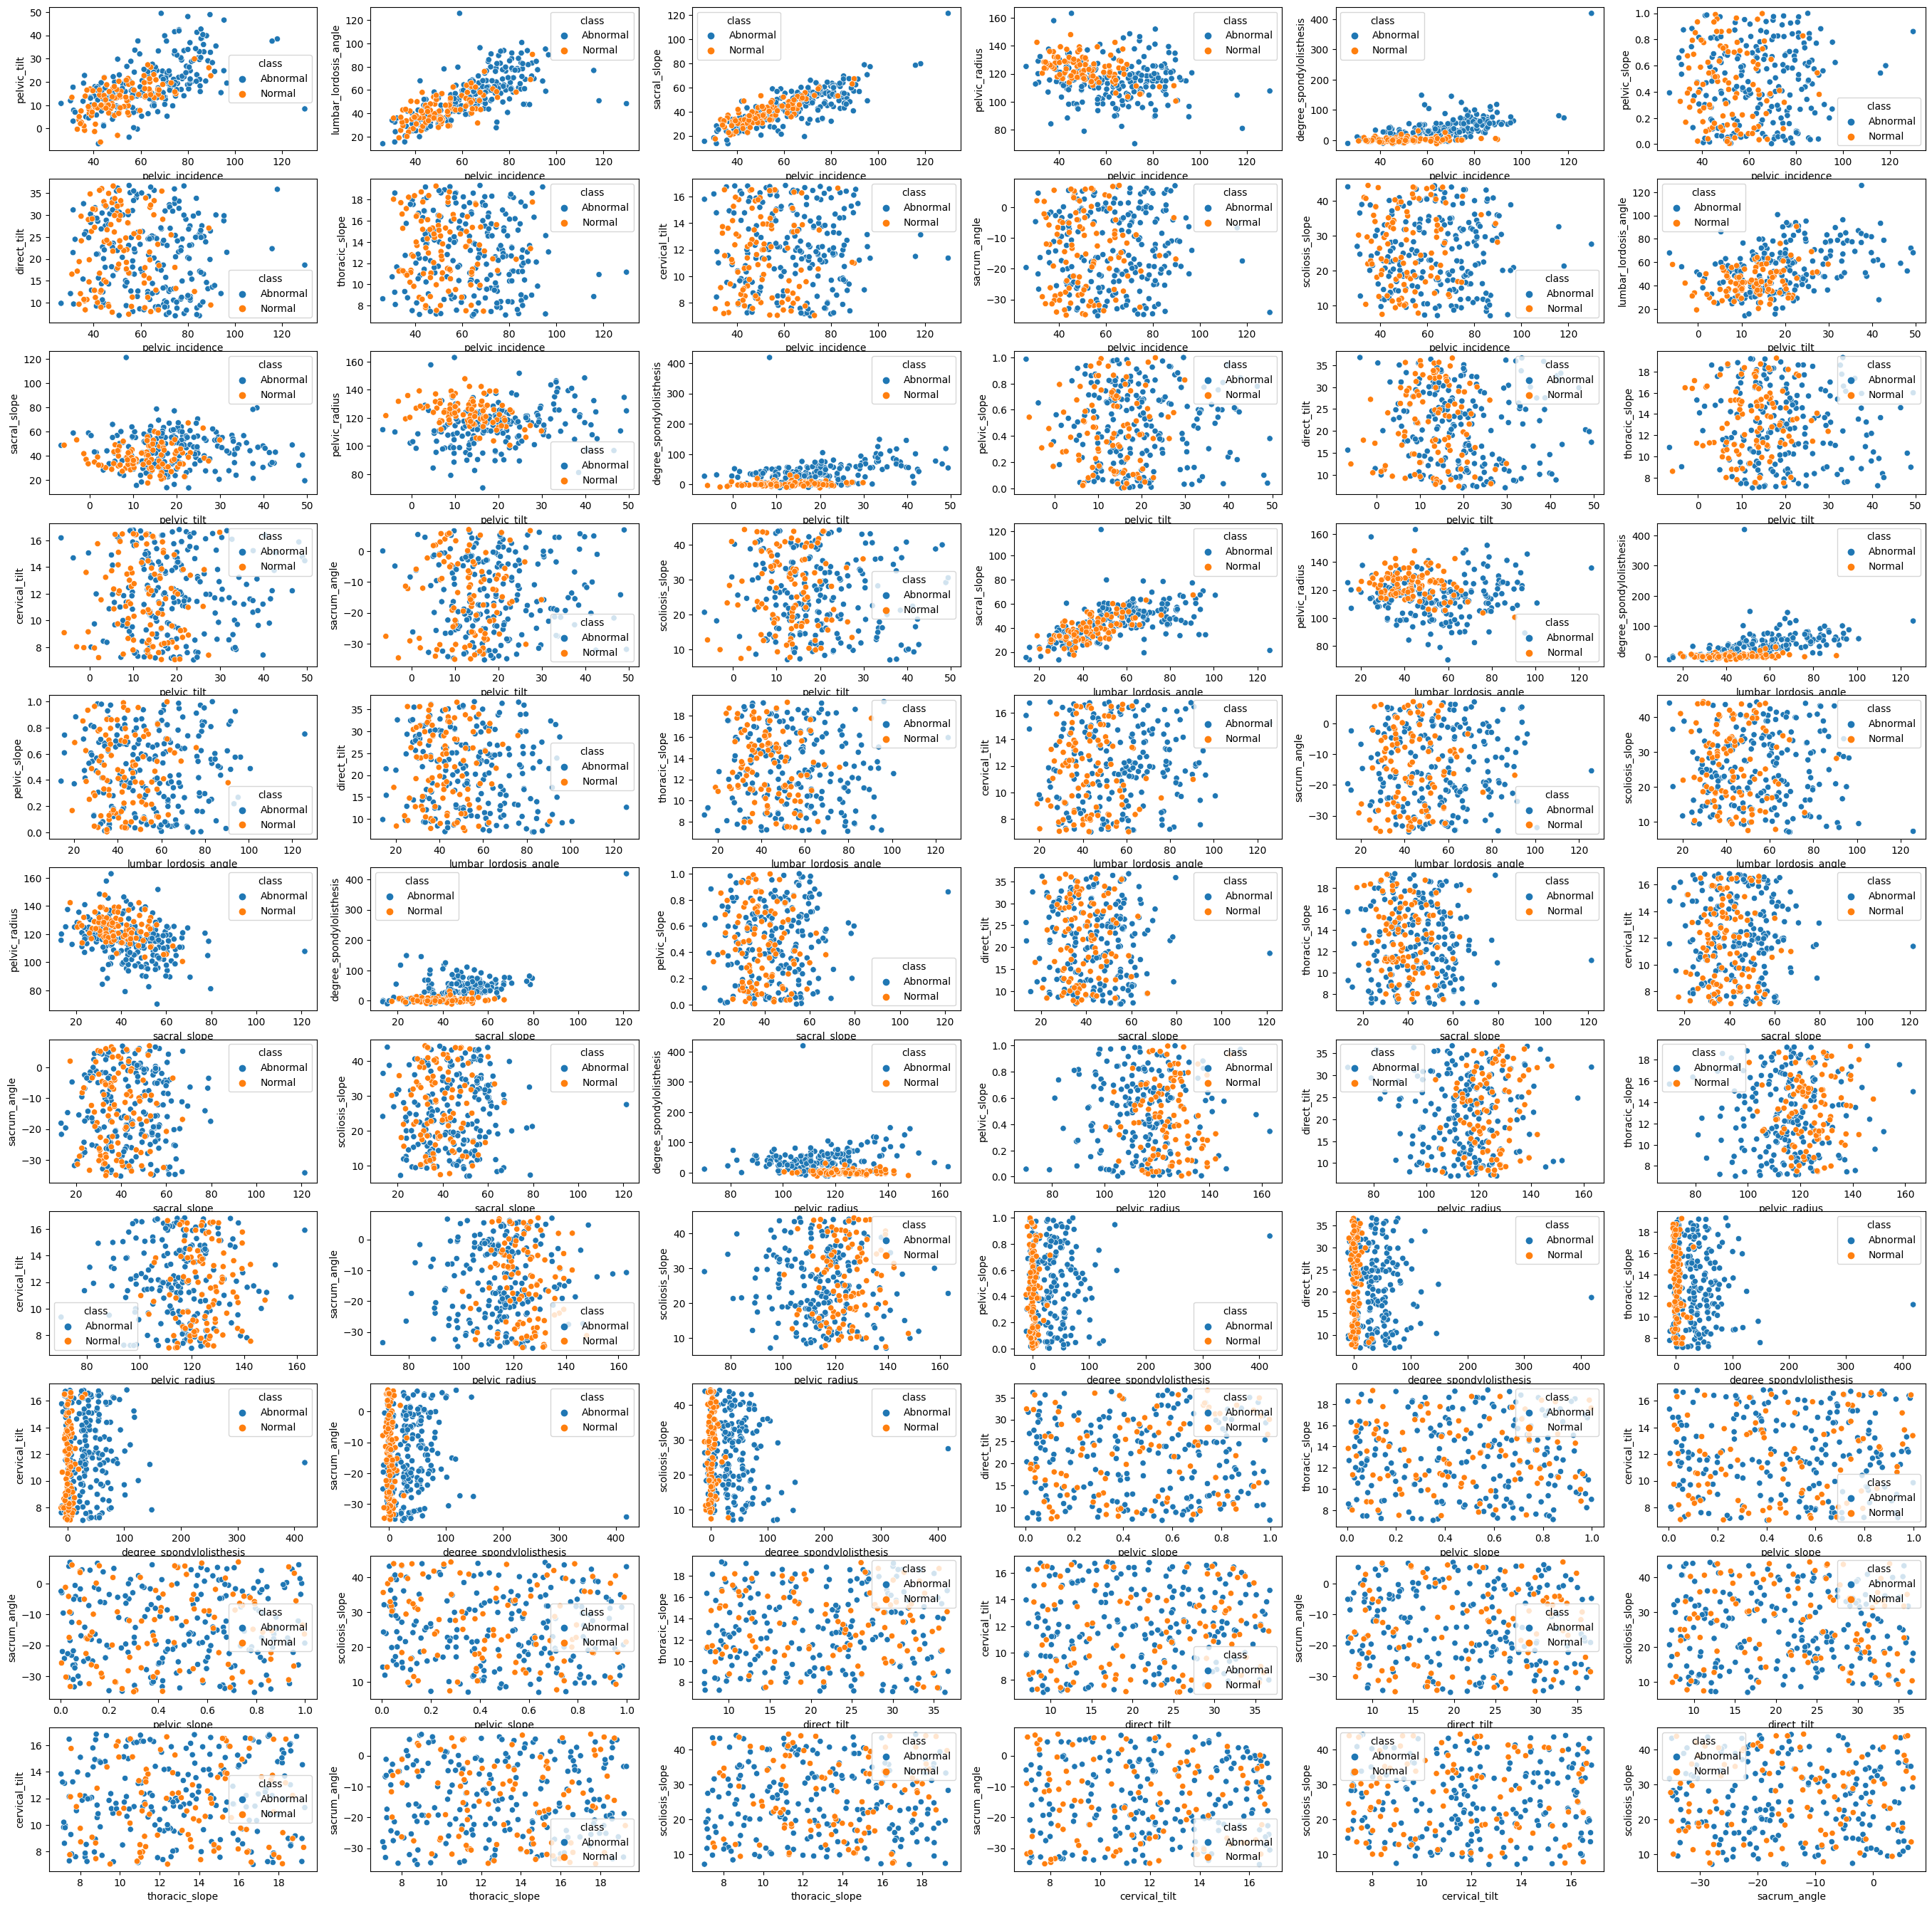

In [251]:
fig, ax = plt.subplots(nrows=11, ncols=6, figsize=(34,34))

i=0
j=0
for pair in pairs:
    if j == 6:
        j=0
        i += 1
    data = base[[pair[0], pair[1], 'class']]
    sns.scatterplot(data=data, x=pair[0], y=pair[1], hue="class", ax=ax[i][j])
    j += 1

plt.show()

#### Separando em treino e teste.

In [252]:
base = base.drop(columns=['class'])

In [253]:
X_ = base.loc[:, base.columns != 'TARGET']
y_ = base.TARGET

X_train, X_test, y_train, y_test = train_test_split(
X_, y_, test_size=0.25, random_state=42)

In [254]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))

In [255]:
X_train.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']
X_test.columns = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

In [256]:
X_train.shape

(232, 12)

In [257]:
X_test.shape

(78, 12)

#### Treinando modelos diferentes
Precisamos definir qual será a métrica de avaliação do modelo, meu palpite é ROC AUC pq tem mais informação. Optar sempre pela menor rede que nos dá bons resultados!

In [283]:
model = MLPClassifier(hidden_layer_sizes=(32,16,8), activation="tanh", random_state=42, max_iter=450)

In [284]:
model.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(32, 16, 8), max_iter=450,
              random_state=42)

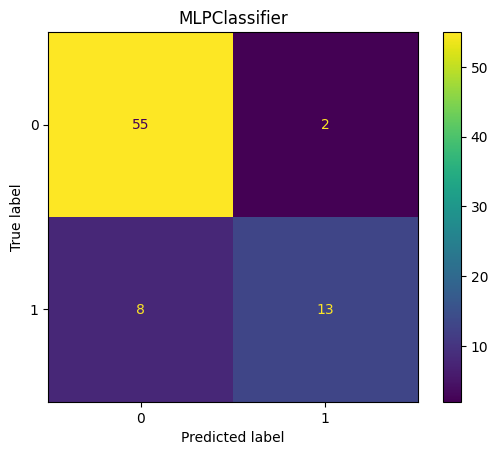

Precision score:  0.8666666666666667
Recall score:  0.6190476190476191
F1 score:  0.7222222222222222
Accuracy score:  0.8717948717948718
ROC AUC score:  0.9406850459482038





In [285]:
plot_confusion_matrix(model, X_test, y_test)

In [292]:
model_2 = MLPClassifier(hidden_layer_sizes=(32,16), activation="tanh", random_state=42, max_iter=450)

In [293]:
model_2.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(32, 16), max_iter=450,
              random_state=42)

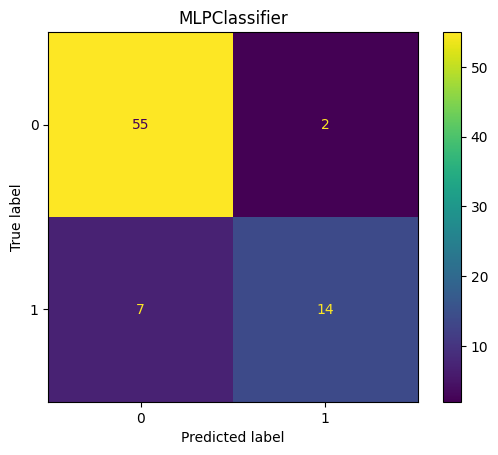

Precision score:  0.875
Recall score:  0.6666666666666666
F1 score:  0.7567567567567567
Accuracy score:  0.8846153846153846
ROC AUC score:  0.9381787802840433





In [294]:
plot_confusion_matrix(model_2, X_test, y_test)

In [313]:
model_3 = MLPClassifier(hidden_layer_sizes=(16,8), activation="tanh", random_state=42, max_iter=850)

In [314]:
model_3.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(16, 8), max_iter=850,
              random_state=42)

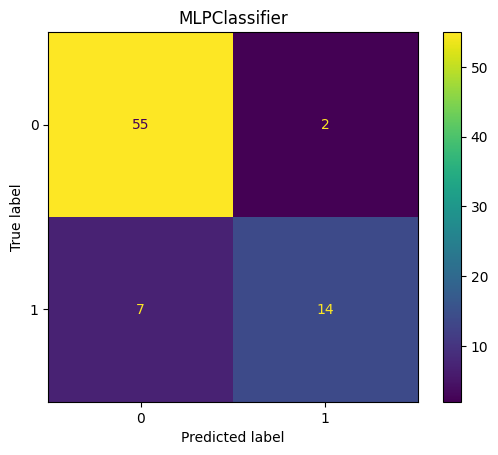

Precision score:  0.875
Recall score:  0.6666666666666666
F1 score:  0.7567567567567567
Accuracy score:  0.8846153846153846
ROC AUC score:  0.9365079365079365





In [315]:
plot_confusion_matrix(model_3, X_test, y_test)

In [326]:
model_4 = MLPClassifier(hidden_layer_sizes=(8,4), activation="tanh", random_state=42, max_iter=1150)

In [327]:
model_4.fit(X_train, y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=(8, 4), max_iter=1150,
              random_state=42)

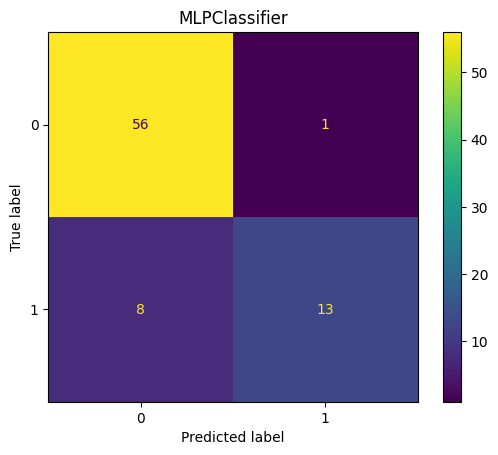

Precision score:  0.9285714285714286
Recall score:  0.6190476190476191
F1 score:  0.742857142857143
Accuracy score:  0.8846153846153846
ROC AUC score:  0.9406850459482038





In [328]:
plot_confusion_matrix(model_4, X_test, y_test)